In [ ]:
# !pip install patchify
# !pip install git+https://github.com/qubvel/segmentation_models.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Mounted at /content/drive
Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
import os

path = "/content/drive/MyDrive/"
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))



import os
import glob
from pprint import pprint

base_dir   = "/content/drive/MyDrive/sample_data_150_tr"
image_pre  = os.path.join(base_dir, "pre_image")
image_post = os.path.join(base_dir, "post_image")
target_dir = os.path.join(base_dir, "target_mask")
label_dir  = os.path.join(base_dir, "label_json")

train_dict = {}

# loop over all target masks
for target_path in glob.glob(os.path.join(target_dir, '*.png')):
    filename = os.path.basename(target_path)
    base_id = filename.replace('.png', '')

    # now filenames match directly
    pre_img  = os.path.join(image_pre,  base_id + '.png')
    post_img = os.path.join(image_post, base_id + '.png')
    label_json = os.path.join(label_dir, base_id + '.json')

    if os.path.exists(pre_img) and os.path.exists(post_img):
        train_dict[base_id] = {
            'pre_image': pre_img,
            'post_image': post_img,
            'target_mask': target_path,
            'label_json': label_json if os.path.exists(label_json) else None
        }
    else:
        print(f"Missing: {base_id}")
        if not os.path.exists(pre_img):
            print(" - Missing pre:", pre_img)
        if not os.path.exists(post_img):
            print(" - Missing post:", post_img)

# Show a sample entry
pprint(dict(list(train_dict.items())[:1]))


/content/drive/MyDrive/sample_data_150
/content/drive/MyDrive/sample_data_150-20250824T171112Z-1-001.zip
/content/drive/MyDrive/best_model_unshared_3_8.keras
/content/drive/MyDrive/santa-rosa-wildfire_00000052_pre_disaster.png
/content/drive/MyDrive/santa-rosa-wildfire_00000181_pre_disaster.png
/content/drive/MyDrive/hurricane-harvey_00000324_pre_disaster.png
/content/drive/MyDrive/palu-tsunami_00000165_pre_disaster.png
/content/drive/MyDrive/segmentation_model_improvments.ipynb
/content/drive/MyDrive/Copy of dmage_class_seg_unshared.ipynb
/content/drive/MyDrive/chagesw_losst_no_bg_3ov_dc.keras
/content/drive/MyDrive/dmage_focalwc_bg_we2.keras
/content/drive/MyDrive/Colab Notebooks/oct_ddmage.ipynb
/content/drive/MyDrive/Colab Notebooks/exp_seg.ipynb
/content/drive/MyDrive/Colab Notebooks/model_build_new.ipynb
/content/drive/MyDrive/Colab Notebooks/unshared_seg_stateligh.ipynb
/content/drive/MyDrive/Colab Notebooks/Copy of dddmage_class_seg_unshared.ipynb
/content/drive/MyDrive/sample_

In [ ]:
from PIL import Image
import pandas as pd
from patchify import patchify
from tqdm import tqdm
import numpy as np

# Step 1 — Create DataFrame from your dictionary
data = []
for key, value in train_dict.items():
    disaster = key.split('_')[0]
    pre_image = value['pre_image']
    post_image = value['post_image']
    target_mask = value['target_mask']
    data.append((disaster, pre_image, post_image, target_mask))

df = pd.DataFrame(data, columns=['disaster_type', 'pre_image_path', 'post_image_path', 'target_mask'])

# Step 2 — Patchify directly from original resolution
patch_size = 256
step = 256


## use 128 at pachies

pre_patches = []
post_patches = []
mask_patches = []

for pre_path, post_path, mask_path in tqdm(zip(df['pre_image_path'], df['post_image_path'], df['target_mask']),
                                           total=len(df),
                                           desc="Patchifying"):

    pre_img = np.array(Image.open(pre_path).convert("RGB"))
    post_img = np.array(Image.open(post_path).convert("RGB"))
    mask_img = np.array(Image.open(mask_path))  # mask stays in label form

    # Skip if shape is not as expected
    if pre_img.shape[0] % patch_size != 0 or pre_img.shape[1] % patch_size != 0:
        print(f"Skipping {pre_path}, unexpected shape: {pre_img.shape}")
        continue

    # Patchify (3 channels for RGB, 1 for mask)
    pre_p = patchify(pre_img, (patch_size, patch_size, 3), step=step)
    post_p = patchify(post_img, (patch_size, patch_size, 3), step=step)
    mask_p = patchify(mask_img, (patch_size, patch_size), step=step)

    # Store patches
    for i in range(pre_p.shape[0]):
        for j in range(pre_p.shape[1]):
            pre_patches.append(pre_p[i, j, 0])
            post_patches.append(post_p[i, j, 0])
            mask_patches.append(mask_p[i, j])


Patchifying: 100%|██████████| 140/140 [04:45<00:00,  2.04s/it]


In [ ]:
dff=df.drop(columns=['disaster_type'])
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pre_image_path   140 non-null    object
 1   post_image_path  140 non-null    object
 2   target_mask      140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


In [ ]:

import numpy as np

np.random.seed(42)

balanced_pre = []
balanced_post = []
balanced_mask = []

for pre_patch, post_patch, mask_patch in zip(pre_patches, post_patches, mask_patches):
    fg_pixels = np.sum(mask_patch > 0)
    total_pixels = mask_patch.size
    fg_ratio = fg_pixels / total_pixels

    if fg_ratio > 0.01:
        balanced_pre.append(pre_patch)
        balanced_post.append(post_patch)
        balanced_mask.append(mask_patch)
    else:
        if np.random.rand() < 0.1:
            balanced_pre.append(pre_patch)
            balanced_post.append(post_patch)
            balanced_mask.append(mask_patch)

print(f"Original patches: {len(pre_patches)}")
print(f"Balanced patches: {len(balanced_pre)}")




# import numpy as np

# np.random.seed(42)

# balanced_pre_final = []
# balanced_post_final = []
# balanced_mask_final = []

# # Define oversample factors (how many times to duplicate)
# oversample_factors = {2: 2, 3: 2, 4: 2}  # oversample these classes
# downsample_prob_class1 = 0.3  # keep 30% of class 1 patches

# for pre_patch, post_patch, mask_patch in zip(balanced_pre, balanced_post, balanced_mask):

#     unique_classes = np.unique(mask_patch)

#     # Downsample class 1 patches
#     if 1 in unique_classes:
#         if np.random.rand() < downsample_prob_class1:
#             balanced_pre_final.append(pre_patch)
#             balanced_post_final.append(post_patch)
#             balanced_mask_final.append(mask_patch)
#     else:
#         # Keep patch if it has fg pixels or other classes
#         balanced_pre_final.append(pre_patch)
#         balanced_post_final.append(post_patch)
#         balanced_mask_final.append(mask_patch)

#     # Oversample other classes
#     for cls, factor in oversample_factors.items():
#         if cls in unique_classes:
#             for _ in range(factor - 1):  # -1 because already added
#                 balanced_pre_final.append(pre_patch)
#                 balanced_post_final.append(post_patch)
#                 balanced_mask_final.append(mask_patch)

# print(f"Original patches: {len(pre_patches)}")
# print(f"Patches after balancing: {len(balanced_pre_final)}")




import numpy as np

np.random.seed(42)

balanced_pre_final = []
balanced_post_final = []
balanced_mask_final = []

# Define oversample factors (how many times to duplicate)
oversample_factors = {2: 3, 3: 3, 4: 2}  # oversample these classes

# Downsample probabilities
downsample_prob_class0 = 0.3  # keep 10% of class 0 patches
downsample_prob_class1 = 0.3  # keep 30% of class 1 patches

for pre_patch, post_patch, mask_patch in zip(balanced_pre, balanced_post, balanced_mask):

    unique_classes = np.unique(mask_patch)

    # Downsample class 0 patches
    if 0 in unique_classes:
        if np.random.rand() < downsample_prob_class0:
            balanced_pre_final.append(pre_patch)
            balanced_post_final.append(post_patch)
            balanced_mask_final.append(mask_patch)
    # Downsample class 1 patches
    elif 1 in unique_classes:
        if np.random.rand() < downsample_prob_class1:
            balanced_pre_final.append(pre_patch)
            balanced_post_final.append(post_patch)
            balanced_mask_final.append(mask_patch)
    else:
        # Keep patch if it has fg pixels or other classes
        balanced_pre_final.append(pre_patch)
        balanced_post_final.append(post_patch)
        balanced_mask_final.append(mask_patch)

    # Oversample other classes
    for cls, factor in oversample_factors.items():
        if cls in unique_classes:
            for _ in range(factor - 1):  # -1 because already added
                balanced_pre_final.append(pre_patch)
                balanced_post_final.append(post_patch)
                balanced_mask_final.append(mask_patch)

print(f"Original patches: {len(pre_patches)}")
print(f"Patches after balancing: {len(balanced_pre_final)}")


Original patches: 2240
Balanced patches: 774
Original patches: 2240
Patches after balancing: 781


In [ ]:
x1 = np.array(balanced_pre_final)
x2 = np.array(balanced_post_final)
y = np.array(balanced_mask_final)

print(x1.shape,x2.shape,y.shape)

print(x1.dtype)
print(x2.dtype)
x1 = x1.astype(np.float16)/255.0
x2 = x2.astype(np.float16)/255.0



from tensorflow.keras.utils import to_categorical

y_binary = (y > 0).astype(np.uint8)
y_seg_pre = y_binary
y_seg_post = y_binary

y_severity = np.where(y_binary, balanced_mask_final, 0).astype(np.uint8)

(781, 256, 256, 3) (781, 256, 256, 3) (781, 256, 256)
uint8
uint8


In [ ]:
from sklearn.model_selection import train_test_split

(x1_train, x1_val,
 x2_train, x2_val,
 y_seg_pre_train, y_seg_pre_val,
 y_seg_post_train, y_seg_post_val,
 y_severity_train, y_severity_val) = train_test_split(
    x1, x2, y_seg_pre, y_seg_post, y_severity,
    test_size=0.3, random_state=42
)



# Initialize a dictionary to store pixel counts
pixel_counts = {c: 0 for c in range(5)}  # Classes 0 to 4

# Count pixels for each class
for c in range(5):
    pixel_counts[c] = np.sum(y_seg_pre_val == c)

# Print the raw pixel counts
print("Pixel Counts:")
for c, count in pixel_counts.items():
    print(f"Class {c}: {count}")

Pixel Counts:
Class 0: 13837126
Class 1: 1563834
Class 2: 0
Class 3: 0
Class 4: 0


In [ ]:
y_seg_pre_train = y_seg_pre_train.astype('float32')
y_seg_pre_val   = y_seg_pre_val.astype('float32')

In [ ]:
y_seg_pre_train = np.expand_dims(y_seg_pre_train, axis=-1).astype('float32')
y_seg_pre_val   = np.expand_dims(y_seg_pre_val, axis=-1).astype('float32')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import segmentation_models as sm


IMG_SIZE = 256
BACKBONE = 'resnet34'  # Pretrained backbone
PRETRAINED = 'imagenet'


def build_building_segmentation_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    # Use a predefined U-Net from segmentation_models
    # Output: 1 channel sigmoid (binary mask)
    model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=input_shape,
        classes=1,
        activation='sigmoid',
        encoder_weights=PRETRAINED
    )
    return model


seg_model = build_building_segmentation_model()
seg_model.summary()






85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# focal = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=2.0)
focal = sm.losses.BinaryFocalLoss(alpha=0.9, gamma=2.0)

@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only keep patches that have some damage
    mask = tf.reduce_sum(y_true, axis=[1,2,3]) > 0
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # If no damage patches exist, return 0
    def compute_iou():
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
        return tf.reduce_mean(intersection / (union + 1e-7))

    return tf.cond(tf.size(y_true) > 0, compute_iou, lambda: 0.0)

@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_f1_per_class(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only damage class
    intersection = tf.reduce_sum(y_true * y_pred)
    precision = intersection / (tf.reduce_sum(y_pred) + 1e-7)
    recall = intersection / (tf.reduce_sum(y_true) + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)


seg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=sm.losses.DiceLoss(class_weights=[0.1, 0.9]) + focal,
    metrics=[sm.metrics.IOUScore(), sm.metrics.FScore(),bulinding_iou,bulinding_f1_per_class]
)


In [ ]:
import albumentations as A
import numpy as np
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
import albumentations as A
import numpy as np

# 1️⃣ Define augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    # Do NOT apply brightness/contrast to masks
], additional_targets={'mask':'mask'})

# 2️⃣ DataGenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=12, augment=False, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = np.array([self.images[i] for i in batch_indices])
        y = np.array([self.masks[i] for i in batch_indices])

        if self.augment:
            X_aug = []
            y_aug = []
            for img, mask in zip(X, y):
                # Convert to uint8 for augmentation
                img_aug = (img * 255).astype(np.uint8)
                mask_aug = (mask * 255).astype(np.uint8) if mask.max() <= 1 else mask.astype(np.uint8)

                # Add channel dim for mask if needed
                if mask_aug.ndim == 2:
                    mask_aug = np.expand_dims(mask_aug, axis=-1)

                augmented = transform(image=img_aug, mask=mask_aug)
                img_aug = augmented['image'].astype(np.float32) / 255.0
                mask_aug = augmented['mask'].astype(np.float32) / 255.0  # back to 0-1 float

                # Squeeze mask back to original shape
                if mask_aug.ndim == 2:
                    mask_aug = np.expand_dims(mask_aug, axis=-1)

                X_aug.append(img_aug)
                y_aug.append(mask_aug)

            X = np.array(X_aug, dtype=np.float32)
            y = np.array(y_aug, dtype=np.float32)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_gen = DataGenerator(x1_train, y_seg_pre_train, batch_size=12, augment=True, shuffle=True)
val_gen = DataGenerator(x1_val, y_seg_pre_val, batch_size=12, augment=False, shuffle=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_bulinding_iou', patience=25, restore_best_weights=True,mode='max')


checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/bulinding_seg_resnet34.keras',
    monitor='val_bulinding_iou',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1

)

history = seg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop,checkpoint]
)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - bulinding_f1_per_class: 0.2271 - bulinding_iou: 0.1201 - f1-score: 0.1907 - iou_score: 0.1063 - loss: 0.9451
Epoch 1: val_bulinding_iou improved from -inf to 0.07054, saving model to /content/drive/MyDrive/bulinding_seg_resnet34.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - bulinding_f1_per_class: 0.2287 - bulinding_iou: 0.1210 - f1-score: 0.1915 - iou_score: 0.1068 - loss: 0.9446 - val_bulinding_f1_per_class: 0.1353 - val_bulinding_iou: 0.0705 - val_f1-score: 0.1650 - val_iou_score: 0.0903 - val_loss: 0.9495
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - bulinding_f1_per_class: 0.4280 - bulinding_iou: 0.2456 - f1-score: 0.2875 - iou_score: 0.1691 - loss: 0.8851
Epoch 2: val_bulinding_iou did not improve from 0.07054
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - bulinding_f1_per_class: 0.4286 - bulinding_iou: 0.2461 - f1-score: 0.2879 - iou_score: 0.1694 - loss: 0.8848 - val_bulinding_f1_per_class: 2.8078e-05 - val_bulinding_iou: 2.9929

 # this is the saved model's plot

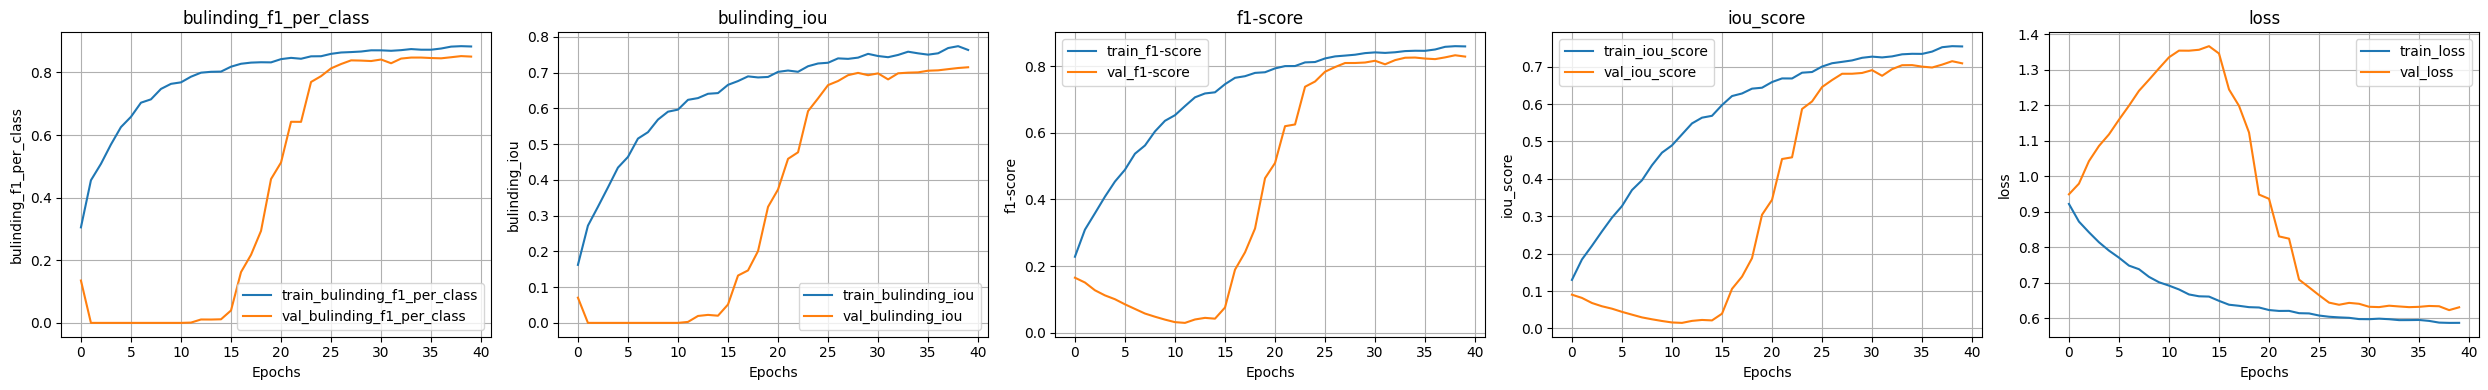

In [ ]:
import matplotlib.pyplot as plt

def plot_history_horizontal(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = ['val_' + m for m in metrics]

    n = len(metrics)
    plt.figure(figsize=(5*n, 4))  # Width depends on number of metrics

    for i, (m, vm) in enumerate(zip(metrics, val_metrics)):
        plt.subplot(1, n, i+1)  # 1 row, n columns
        plt.plot(history.history[m], label='train_' + m)
        plt.plot(history.history[vm], label='val_' + m)
        plt.title(m)
        plt.xlabel('Epochs')
        plt.ylabel(m)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history_horizontal(history)


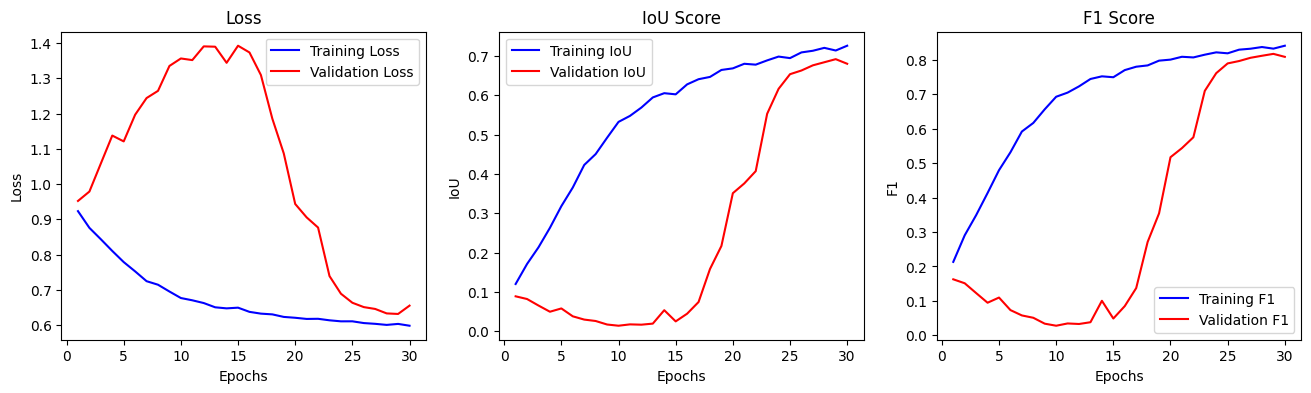

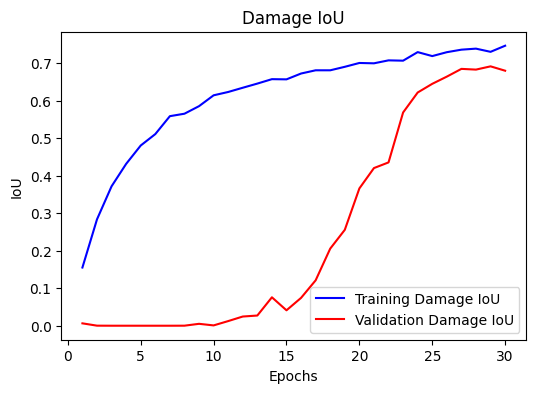

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

f1 = history.history['f1-score']
val_f1 = history.history['val_f1-score']

damage_iou_metric = history.history.get('damage_iou', None)
val_damage_iou_metric = history.history.get('val_damage_iou', None)

epochs = range(1, len(loss)+1)

# Plot Loss
plt.figure(figsize=(1,4))
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU
plt.subplot(1,3,2)
plt.plot(epochs, iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plot F1-score
plt.subplot(1,3,3)
plt.plot(epochs, f1, 'b-', label='Training F1')
plt.plot(epochs, val_f1, 'r-', label='Validation F1')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.show()

# Optional: Damage IoU plot if available
if damage_iou_metric and val_damage_iou_metric:
    plt.figure(figsize=(6,4))
    plt.plot(epochs, damage_iou_metric, 'b-', label='Training Damage IoU')
    plt.plot(epochs, val_damage_iou_metric, 'r-', label='Validation Damage IoU')
    plt.title('Damage IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()


    # this chart is with same setup but just added on more metric and that is the f1_per class


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model(
#     "/content/drive/MyDrive/bulinding_seg_resnet34.keras",
#     custom_objects={
#         "bulinding_iou": bulinding_iou,
#         "bulinding_f1_per_class": bulinding_f1_per_class
#     },
#     compile=False  # safer for custom losses
# )